In [1]:
import json
import gzip
from pathlib import Path
import pandas as pd


In [2]:
def load_nvd_json(path):
    if path.suffix == ".gz":
        with gzip.open(path, "rt", encoding="utf-8") as f:
            return json.load(f)
    else:
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f)


In [3]:
import xml.etree.ElementTree as ET

def load_cwe_id_name_map(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    ns = {"cwe": "http://cwe.mitre.org/cwe-7"}
    cwe_map = {}

    for weakness in root.findall("cwe:Weaknesses/cwe:Weakness", ns):
        cwe_id = f"CWE-{weakness.attrib['ID']}"
        cwe_name = weakness.attrib.get("Name", "")
        cwe_map[cwe_id] = f"{cwe_id}: {cwe_name}"

    return cwe_map


In [4]:
def extract_cve_records_v2(nvd_json):
    records = []

    for item in nvd_json.get("vulnerabilities", []):
        cve = item.get("cve", {})

        # --------------------
        # Description (English)
        # --------------------
        descriptions = cve.get("descriptions", [])
        desc = next(
            (d["value"] for d in descriptions if d.get("lang") == "en"),
            None
        )
        if not desc:
            continue

        # --------------------
        # CWE extraction
        # --------------------
        cwes = []
        for weakness in cve.get("weaknesses", []):
            for desc_item in weakness.get("description", []):
                val = desc_item.get("value", "")
                if val.startswith("CWE-"):
                    cwes.append(val)

        # keep only single-label CVEs
        cwes = list(set(cwes))
        if len(cwes) != 1:
            continue

        cwe = cwes[0]
        if cwe in {"NVD-CWE-Other", "NVD-CWE-noinfo"}:
            continue

        records.append({
            "input": desc.strip(),
            "output": cwe
        })

    return records


In [5]:
nvd_path = Path("../data/nvd/nvdcve-2.0-2026.json.gz")
nvd_json = load_nvd_json(nvd_path)

records = extract_cve_records_v2(nvd_json)
df = pd.DataFrame(records)

print("Total usable CVEs:", len(df))
print(df.head())


Total usable CVEs: 1036
                                               input   output
0  cpp-httplib is a C++11 single-file header-only...   CWE-93
1  eopkg is a Solus package manager implemented i...   CWE-24
2  eopkg is a Solus package manager implemented i...  CWE-353
3  Emlog is an open source website building syste...  CWE-862
4  Emlog is an open source website building syste...   CWE-79


In [6]:
top_k = 20
top_cwes = df["output"].value_counts().head(top_k).index
df = df[df["output"].isin(top_cwes)]


## Plot Top-K CWE categories

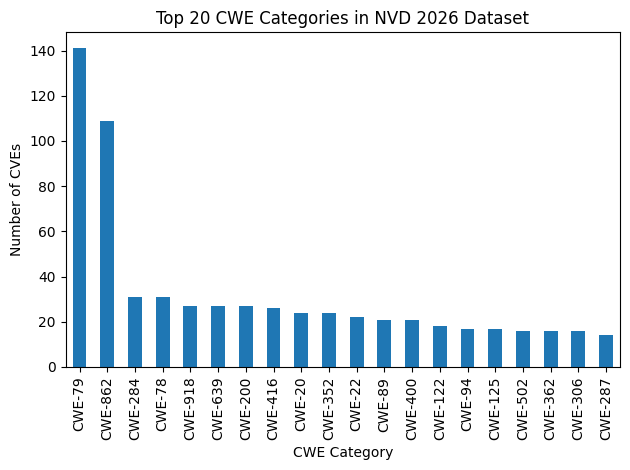

In [7]:
import matplotlib.pyplot as plt

top_counts = df["output"].value_counts().head(top_k)

plt.figure()
top_counts.plot(kind="bar")
plt.xlabel("CWE Category")
plt.ylabel("Number of CVEs")
plt.title(f"Top {top_k} CWE Categories in NVD 2026 Dataset")
plt.tight_layout()
plt.show()


In [9]:
cwe_map = load_cwe_id_name_map("../data/nvd/cwec_v4.19.1.xml")
print(cwe_map["CWE-79"])


CWE-79: Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting')


In [10]:
df["instruction"] = "Classify the vulnerability type."
df = df[["instruction", "input", "output"]]
df["output"] = df["output"].map(cwe_map)

In [11]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["output"]
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df["output"]
)


In [12]:
out_dir = Path("../data/nvd/processed")
out_dir.mkdir(parents=True, exist_ok=True)

for split, split_df in {
    "train": train_df,
    "val": val_df,
    "test": test_df
}.items():
    split_df.to_json(
        out_dir / f"{split}.json",
        orient="records",
        indent=2
    )
